In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vincentpssun","key":"d26a8a70aa40ef0a22d3d6e2fd68eab8"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:22<00:00, 17.4MB/s]
100% 2.29G/2.29G [01:23<00:00, 29.7MB/s]


In [ ]:
! mkdir Pneumonia

In [ ]:
! unzip chest-xray-pneumonia.zip -d Pneumonia

In [ ]:
import os, shutil

path_name = './Pneumonia/chest_xray'
dir_length = len(os.listdir(path_name))
os.listdir(path_name)

['chest_xray', 'train', '__MACOSX', 'val', 'test']

In [ ]:
train_dir = './Pneumonia/chest_xray/train'
val_dir = './Pneumonia/chest_xray/val'
test_dir = './Pneumonia/chest_xray/test'

print(len(os.listdir(train_dir)), len(os.listdir(val_dir)), len(os.listdir(test_dir)))

2 2 2


In [ ]:
print("No. of Normal Training Images: ", len(os.listdir(train_dir+'/NORMAL')), "No of Pneumonia Training Iages: ", len(os.listdir(train_dir+'/PNEUMONIA')))
print("No. of Normal Testing Images: ", len(os.listdir(test_dir+'/NORMAL')), "No of Pneumonia Testing Iages: ", len(os.listdir(test_dir+'/PNEUMONIA')))
print("No. of Normal Validation Images: ", len(os.listdir(val_dir+'/NORMAL')), "No of Pneumonia Validation Iages: ", len(os.listdir(val_dir+'/PNEUMONIA')))

No. of Normal Training Images:  1341 No of Pneumonia Training Iages:  3875
No. of Normal Testing Images:  234 No of Pneumonia Testing Iages:  390
No. of Normal Validation Images:  8 No of Pneumonia Validation Iages:  8


Since there is a significant weight inbalance between the two training class (1341 for Normal images vs 3875 for Pneumonia), a weight balance for the loss will need to be accounted for during the training phase.

In [ ]:
normal_image_count = len(os.listdir(train_dir+'/NORMAL'))
pneumonia_image_count = len(os.listdir(train_dir+'/PNEUMONIA'))
total_image_count = normal_image_count + pneumonia_image_count

In [ ]:
import numpy as np # linear algebra
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
%matplotlib inline

In [ ]:
weight_for_normal = 1/(normal_image_count/total_image_count)
weight_for_pneumonia = 1/(pneumonia_image_count/total_image_count)
training_weight = torch.FloatTensor([weight_for_normal, weight_for_pneumonia])

In [ ]:
train_data_transform = transforms.Compose([
                                     transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor()
])
val_test_data_transform = transforms.Compose([
                                     transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor()
])

In [ ]:
train_data = torchvision.datasets.ImageFolder(
    root=train_dir,
    transform=train_data_transform
)

test_data = torchvision.datasets.ImageFolder(
    root=test_dir,
    transform=val_test_data_transform
)

val_data = torchvision.datasets.ImageFolder(
    root=val_dir,
    transform=val_test_data_transform
)

In [ ]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=128,
    drop_last=True,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=128,
    shuffle=False
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_data,
    batch_size=16,
    shuffle=False
)

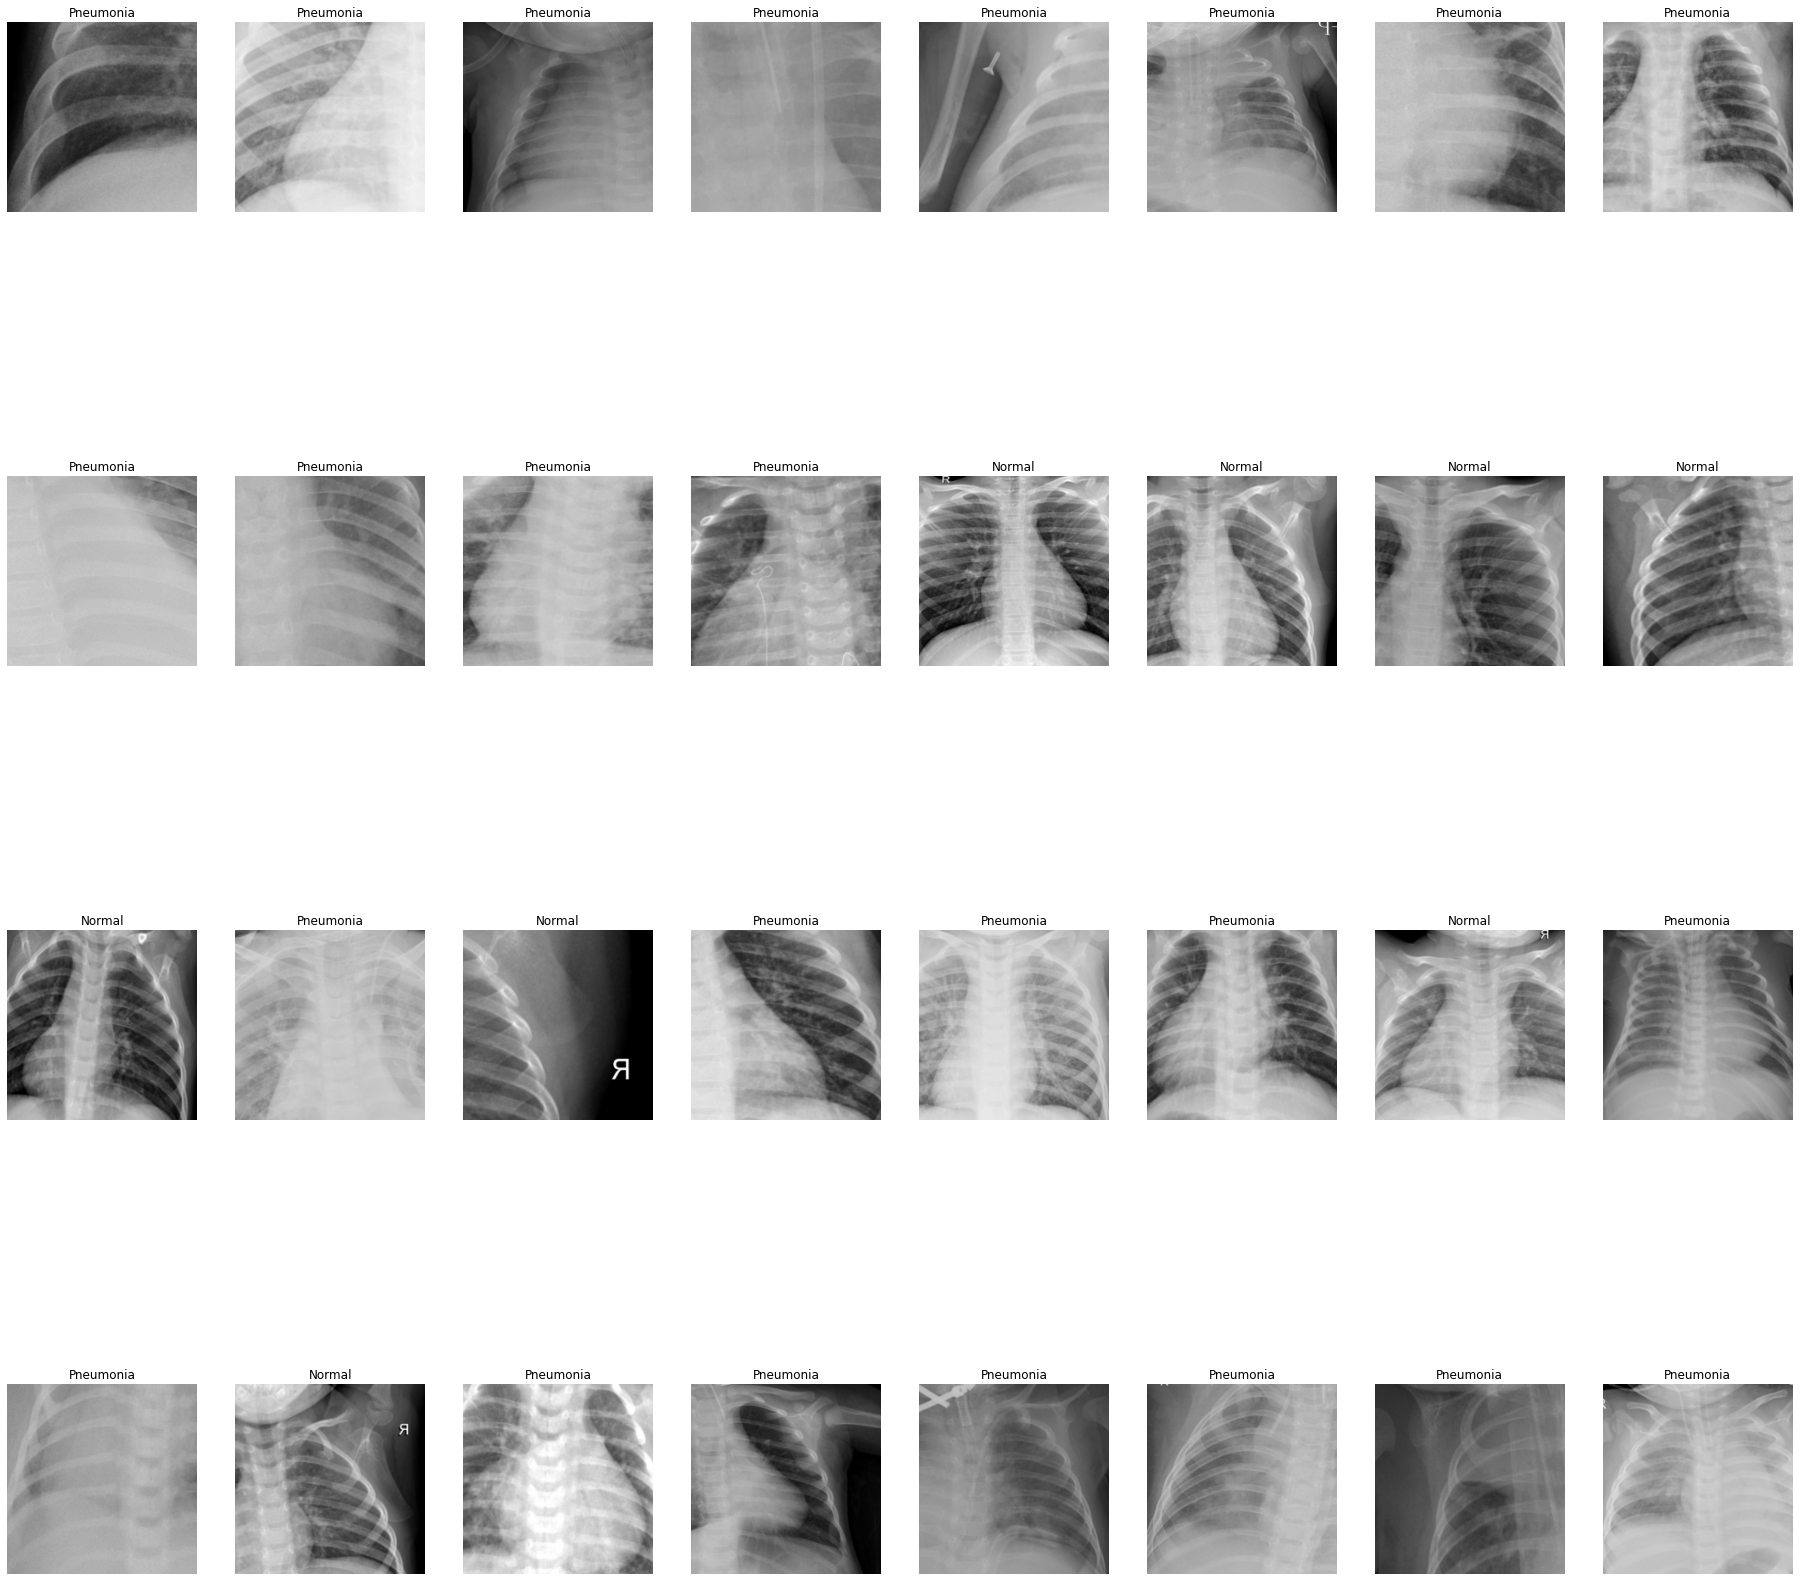

In [ ]:
tag = {0:'Normal', 1:'Pneumonia'}
samples, labels = iter(train_loader).next()
labels = [l.item() for l in labels[:32]]
plt.figure(figsize=(32,32))
for i, sample in enumerate(samples[:32]):
  plt.subplot(4, 8, i+1)
  plt.title(tag[labels[i]])
  plt.axis('off')
  sample = sample.numpy()
  plt.imshow(np.transpose(sample, (1,2,0)))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
model = torchvision.models.resnet50(pretrained=True)

In [ ]:
print(model)

In [ ]:
for param in model.parameters():
  param.require_grad = False

In [ ]:
input_features = model.fc.in_features

new_fc = nn.Sequential(
    nn.Linear(input_features, 2)
)

model.fc = new_fc

In [ ]:
criterion = nn.CrossEntropyLoss(weight=training_weight).to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=4e-4) # weight_decay for l2 regularistion, 4e-4 is the most used in literature https://arxiv.org/pdf/1803.09820.pdf

In [ ]:
epochs = 20
total_step = len(train_loader)
model.to(device)
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []
train_total_loss = 0
train_acc = 0
val_acc, val_loss = 0, 0
per_iteration = 100
print(total_step)

40


In [ ]:
for epoch in range(epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    #Forward Pass
    model.train()
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backpass and Optimise
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    train_total_loss += loss.item()

    #if (i+1)%per_iteration == 0:
    if (i+1) == total_step:
      # Train
      _, pred = torch.max(outputs, dim=1)
      train_acc = (pred.data == labels.data).sum()/len(pred)

      # Validation
      model.eval()
      with torch.no_grad():
        val_correct = 0
        val_total = 0
        val_len = len(val_loader)
        total = 0
        val_loss_temp = 0
        for imgs, labs in test_loader:
        #for imgs, labs in val_loader:
          imgs = imgs.to(device)
          labs = labs.to(device)
          val_outputs = model(imgs)
          val_loss1 = criterion(val_outputs, labs)
          predicted = torch.argmax(val_outputs, dim=1)
          val_correct += (predicted == labs).sum()
          val_loss_temp += val_loss1.item()
          total += len(predicted)
        val_acc = val_correct/total
        val_loss = val_loss_temp/total
      
      print('Epoch: {}/{}, Step: {}/{}, Train_Loss: {:.4f}, Train_Acc: {:.4f}, Val_Loss: {:.4f}, Val_Acc: {:.4f}'.format(epoch+1, epochs, i+1, total_step, train_total_loss/per_iteration, train_acc, val_loss, val_acc))

      train_loss_list.append(train_total_loss/per_iteration)
      train_acc_list.append(train_acc)
      val_loss_list.append(val_loss)
      val_acc_list.append(val_acc)
      train_total_loss = 0
      train_acc = 0
      val_acc = 0
      val_loss = 0


Epoch: 1/20, Step: 40/40, Train_Loss: 0.1008, Train_Acc: 0.9297, Val_Loss: 0.0012, Val_Acc: 0.9487
Epoch: 2/20, Step: 40/40, Train_Loss: 0.0508, Train_Acc: 0.9531, Val_Loss: 0.0035, Val_Acc: 0.8590
Epoch: 3/20, Step: 40/40, Train_Loss: 0.0520, Train_Acc: 0.9531, Val_Loss: 0.0017, Val_Acc: 0.9439
Epoch: 4/20, Step: 40/40, Train_Loss: 0.0443, Train_Acc: 0.9844, Val_Loss: 0.0012, Val_Acc: 0.9535
Epoch: 5/20, Step: 40/40, Train_Loss: 0.0413, Train_Acc: 0.9766, Val_Loss: 0.0031, Val_Acc: 0.8766
Epoch: 6/20, Step: 40/40, Train_Loss: 0.0419, Train_Acc: 0.9688, Val_Loss: 0.0032, Val_Acc: 0.8766
Epoch: 7/20, Step: 40/40, Train_Loss: 0.0434, Train_Acc: 0.9531, Val_Loss: 0.0020, Val_Acc: 0.9247
Epoch: 8/20, Step: 40/40, Train_Loss: 0.0398, Train_Acc: 0.9766, Val_Loss: 0.0012, Val_Acc: 0.9359
Epoch: 9/20, Step: 40/40, Train_Loss: 0.0362, Train_Acc: 0.9609, Val_Loss: 0.0017, Val_Acc: 0.9359
Epoch: 10/20, Step: 40/40, Train_Loss: 0.0311, Train_Acc: 0.9531, Val_Loss: 0.0011, Val_Acc: 0.9599
Epoch: 11

<function matplotlib.pyplot.show>

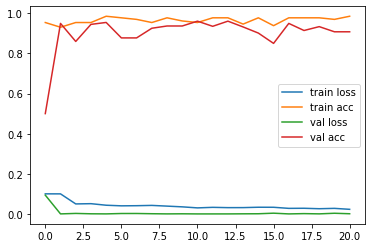

In [ ]:
plt.plot(train_loss_list, label='train loss')
plt.plot(train_acc_list, label='train acc')
plt.plot(val_loss_list, label='val loss')
plt.plot(val_acc_list, label='val acc')
l1 = plt.legend(loc="best")
plt.show

In [ ]:
test_acc = 0;
test_loss = 0
test_total = 0
with torch.no_grad():
  model.eval()
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    temp_loss = criterion(outputs, labels)

    test_loss += temp_loss.item()

    _, preds = torch.max(outputs, dim=1)

    test_acc += (preds == labels).sum()
    test_total += len(images)

avg_acc = test_acc/test_total
avg_loss = test_loss/test_total

print("Test Samples Accuracy is: {:.4f}, Loss is: {:.4f}".format(avg_acc, avg_loss))  

Test Samples Accuracy is: 0.9071, Loss is: 0.0019


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

modelname = 'model_resnet18_1Linear_20epochs_128_batch_size.ckpt'
path = F"/content/gdrive/My Drive/{modelname}"
torch.save(model.state_dict(), path)

Mounted at /content/gdrive
